<a href="https://colab.research.google.com/github/StevenGelpud/BackendJeasonGelpud/blob/main/Modelo_de_predicci%C3%B3n_de_arritmias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar las dependencias necesarias

In [82]:

!pip install wfdb numpy scipy scikit-learn matplotlib seaborn


#Subir datos de MIT-BIH desde Google Drive

In [83]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
base_path = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0'


# Listar archivos en el directorio y visualizar con los datos con los que contamos

In [85]:
import os

records = [f for f in os.listdir(base_path) if f.endswith('.dat')]
print("Archivos disponibles:", records)


Archivos disponibles: ['100.dat', '101.dat', '102.dat', '103.dat', '104.dat', '105.dat', '106.dat', '107.dat', '118.dat', '119.dat', '200.dat', '201.dat', '202.dat', '203.dat', '205.dat', '207.dat', '208.dat', '209.dat', '210.dat', '212.dat', '213.dat', '214.dat', '215.dat', '217.dat', '219.dat', '108.dat', '109.dat', '111.dat', '112.dat', '113.dat', '114.dat', '115.dat', '116.dat', '117.dat', '121.dat', '122.dat', '123.dat', '124.dat', '220.dat', '221.dat', '222.dat', '223.dat', '228.dat', '230.dat', '231.dat', '232.dat', '233.dat', '234.dat']


#Modelo de predicción

In [86]:
import wfdb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

base_path = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'
records_to_load = [i for i in range(100, 234) if i != 110 and not (125 <= i <= 199)]

features = []
labels = []

print(f"Total de registros seleccionados: {len(records_to_load)}")

for record_num in records_to_load:
    try:
        record = wfdb.rdrecord(f'{base_path}{record_num}', sampto=10000)
        signal = record.p_signal

        if np.any(np.isnan(signal)):
            continue

        annotations = wfdb.rdann(f'{base_path}{record_num}', 'atr', sampto=10000)
        label = annotations.symbol
        signal = signal[:, 0]

        max_amp = np.max(signal)
        min_amp = np.min(signal)
        std_dev = np.std(signal)
        features.append([max_amp, min_amp, std_dev])
        labels.append(0 if 'N' in label else 1)
    except Exception as e:
        print(f"registro no encontrado")

features = np.array(features)
labels = np.array(labels)

smote = SMOTE(random_state=42)
features_res, labels_res = smote.fit_resample(features, labels)

X_train, X_test, y_train, y_test = train_test_split(features_res, labels_res, test_size=0.3, random_state=42)

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = {}
y_preds_by_kernel = {}

for kernel in kernels:
    print(f"\nEntrenando SVM con kernel: {kernel}")
    model = make_pipeline(StandardScaler(), SVC(kernel=kernel, class_weight='balanced', gamma='auto'))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_preds_by_kernel[kernel] = y_pred
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[kernel] = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }

print("\nResultados comparativos:")
for kernel, metrics in results.items():
    print(f"Kernel: {kernel}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1-score']:.4f}\n")

best_kernel = max(results, key=lambda k: results[k]['f1-score'])
print(f"El mejor kernel es '{best_kernel}' con {results[best_kernel]['accuracy']:.4f}.")


from sklearn.model_selection import GridSearchCV

# Parámetros para el kernel 'rbf'
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.01, 0.1, 1, 10],
}

pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', class_weight='balanced'))

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Total de registros seleccionados: 58
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado
registro no encontrado

Entrenando SVM con kernel: linear

Entrenando SVM con kernel: rbf

Entrenando SVM con kernel: poly

Entrenando SVM con kernel: sigmoid

Resultados comparativos:
Kernel: linear
  Accuracy: 0.4762
  Precision: 0.4960
  Recall: 0.4762
  F1-Score: 0.4762

Kernel: rbf
  Accuracy: 0.6667
  Precision: 0.6727
  Recall: 0.6667
  F1-Score: 0.6682

Kernel: poly
  Accuracy: 0.5238
  Precision: 0.4929
  Recall: 0.5238
  F1-Score: 0.4898

Kernel: sigmoid
  Accuracy: 0.5238
  Precision: 0.5102
  Recall: 0.5238
  F1-Score: 0.5124

El mejor kernel es 'rbf' con 0.6667.
Fitting 5 folds for each of 16 candidates, totalling 80 fits


#Mejoras y soluciones implementadas

In [87]:


records_to_load = [
    '100', '101', '102', '103', '102', '100', '101', '102', '103', '104', '105', '106', '107',
    '118', '119', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213',
    '214', '215', '217', '219', '108', '109', '111', '112', '113', '114', '115', '116', '117',
    '121', '122', '123', '124', '220', '221', '222', '223', '228', '230', '231', '232', '233',
    '234'
]


features, labels = [], []

for record_id in records_to_load:
    record = wfdb.rdrecord(f'{base_path}/{record_id}', sampto=10000)
    signal = record.p_signal[:, 0]
    annotations = wfdb.rdann(f'{base_path}/{record_id}', 'atr', sampto=10000).symbol

    for i in range(len(annotations)):
        label = 1 if annotations[i] == 'N' else 0

        features.append([np.max(signal), np.min(signal), np.std(signal), np.sum(signal ** 2)])
        labels.append(label)


features = np.array(features)
labels = np.array(labels)

smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)


X_train, X_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


# Resultados de modelo **mejorado**

In [74]:
print(f'\nKernel: {best_model.kernel}')
print(f'Accuracy: {accuracy:.2f}\n')

# Evaluación
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Arritmia', 'Normal']))

accuracy = accuracy_score(y_test, y_pred)


Kernel: rbf
Accuracy: 0.91

              precision    recall  f1-score   support

    Arritmia       0.94      0.86      0.90       382
      Normal       0.87      0.95      0.91       380

    accuracy                           0.91       762
   macro avg       0.91      0.91      0.91       762
weighted avg       0.91      0.91      0.91       762



# Mostrar resultados de la sintonización de hiperparámetros

In [69]:
print("\nResultados completos de la búsqueda de hiperparámetros:")
for mean_score, std_score, params in zip(
    grid_search.cv_results_['mean_test_score'],
    grid_search.cv_results_['std_test_score'],
    grid_search.cv_results_['params']
):
    print(f"Parámetros: {params}")

best_model = grid_search.best_estimator_
print(f"\nMejores hiperparámetros: {grid_search.best_params_}")
print("\n")


Resultados completos de la búsqueda de hiperparámetros:
Parámetros: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Parámetros: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Parámetros: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Parámetros: {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
Parámetros: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Parámetros: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Parámetros: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Parámetros: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
Parámetros: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Parámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Parámetros: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Parámetros: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Parámetros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Parámetros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Parámetros: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Parámetros: {'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Mejores hiperparámetros: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}




# Curva ROC

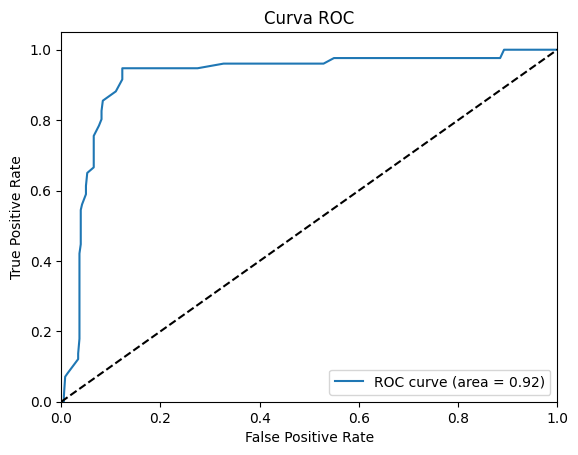

In [75]:

y_score = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print("\n")

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Matriz de Confusión

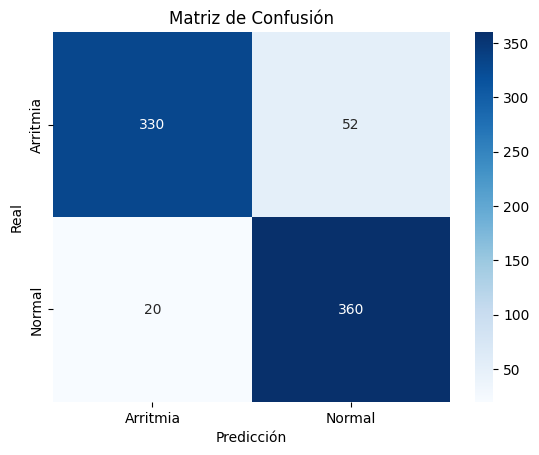

In [71]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Arritmia', 'Normal'], yticklabels=['Arritmia', 'Normal'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

print("\n")


#Implementacion del modelo para predecir la Arritmia de una paciente determinado

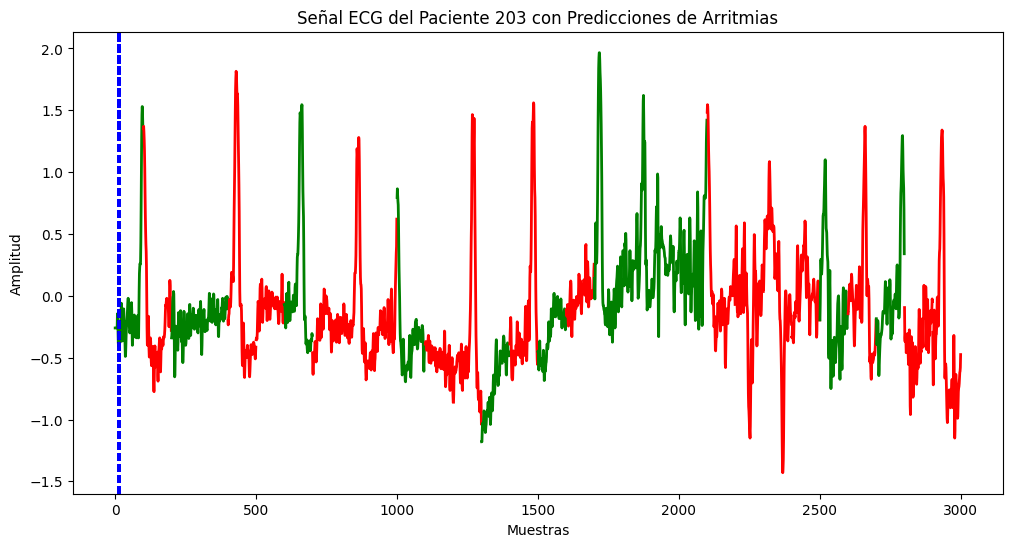

In [72]:
record_id = '203'
record = wfdb.rdrecord(f'{base_path}/{record_id}', sampto=3000)
signal = record.p_signal[:, 0]

annotations = wfdb.rdann(f'{base_path}/{record_id}', 'atr').symbol
window_size = 100
y_pred_extended = np.tile(y_pred, int(np.ceil(len(signal) / len(y_pred))))[:len(signal)]


plt.figure(figsize=(12, 6))


for i in range(len(signal) // window_size):
    start = i * window_size
    end = start + window_size
    if y_pred_extended[start] == 0:
        plt.plot(np.arange(start, end), signal[start:end], color='red', lw=2)
    else:  # Predicción normal
        plt.plot(np.arange(start, end), signal[start:end], color='green', lw=2)


for annotation in annotations:
    if annotation == 'V' or annotation == 'A':
        plt.axvline(x=annotations.index(annotation), color='blue', linestyle='--')

# Detalles de la gráfica
plt.title(f'Señal ECG del Paciente {record_id} con Predicciones de Arritmias')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.show()

